In [1]:
%matplotlib inline

## I/O - Reading and writing transforms
This notebook showcases the `nitransforms.io` module, which implements the input/output operations that allow this library to use other software packages' formats and tools for transforms.

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [2]:
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import nibabel as nb
import nitransforms as nt
from nitransforms.resampling import apply

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(f"This notebook is being executed under <{os.getcwd()}>.")

This notebook is being executed under </private/var/folders/l9/0lkn3g4s27bgkk75n6jj778r0000gp/T/tmpx7qowz2n>.


In [3]:
anat_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / ".nitransforms"))) / "someones_anatomy.nii.gz"

### Load in one sample image
We pick *NiBabel*'s example dataset called `someones_anatomy.nii.gz`.
This is a 3D T1-weighted MRI image stored in NIfTI format.
Before any transformation, let's first visualize the example image, and retain some copies of the original header and affine.
Although it is not the only use-case for 3D images, most often when working with spatial transforms it is the case that at least one 3D image is involved.


Depending on how the software implements the functional that converts coordinates between two reference systems (which is, in essence, the transformation itself), the input/output images may play a role in defining said reference systems.
The most common scenario where images are important to the definition of the spatial transform is that of image alignment (that is, resolving the *image registration* problem), where the algorithm works with the *image's array coordinates*).
Obviously, in such a framework, it is impossible to interpret any given transform without knowing the image(s) that define the *real* coordinates.

<OrthoSlicer3D: /Users/oesteban/datalad/nitransforms-tests/someones_anatomy.nii.gz (57, 67, 56)>

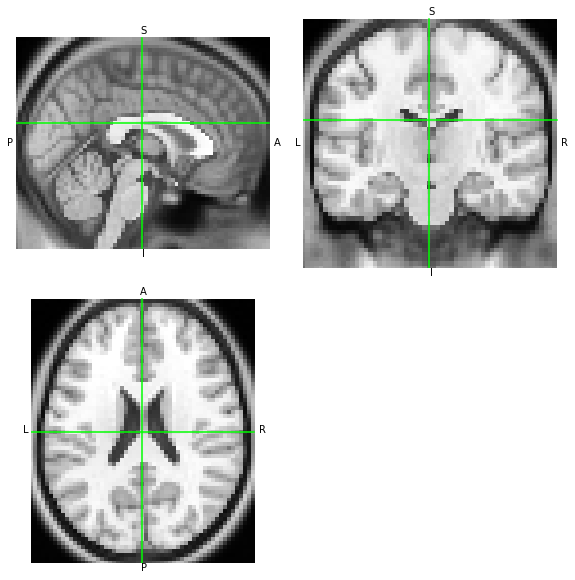

In [4]:
# Load the example
nii = nb.load(anat_file)
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

### Image orientation
NIfTI images have two header entries to define how the data array indexed by integer coordinates between (0, 0, 0) and ($S_i - 1$, $S_j - 1$, $S_k - 1$) maps onto a continous space of, e.g., *scanner coordinates* (typically in mm).
In order to ensure *NiTransforms* implements all possible combinations of transform formats and image orientations, we will need to generate similar images with different *orientations*.

To do so, we will use the `nitransforms.tests.test_io._generate_reoriented(path, directions, swapaxes, parameters)` function.

In [5]:
from nitransforms.tests.test_io import _generate_reoriented

For instance, we may want to generate an image in *LAS* orientation, where the first axis' direction has been flipped and coordinates with positive sign get further away from the origin towards the left, rather than the right (i.e., RAS).

In [6]:
las_anatomy, _ = _generate_reoriented(anat_file, (-1, 1, 1), None, {"x": 0, "y": 0, "z": 0})
print(f"Orientation: {''.join(nb.aff2axcodes(las_anatomy.affine))}.")
print(f"Orientation of the original file: {''.join(nb.aff2axcodes(nii.affine))}.")

Orientation: LAS.
Orientation of the original file: RAS.


Because both orientations point to the same spatial mapping of T1w MRI measurements, with the LAS array having the first axis reversed, both images should look the same when visualized:

<OrthoSlicer3D: (57, 67, 56)>

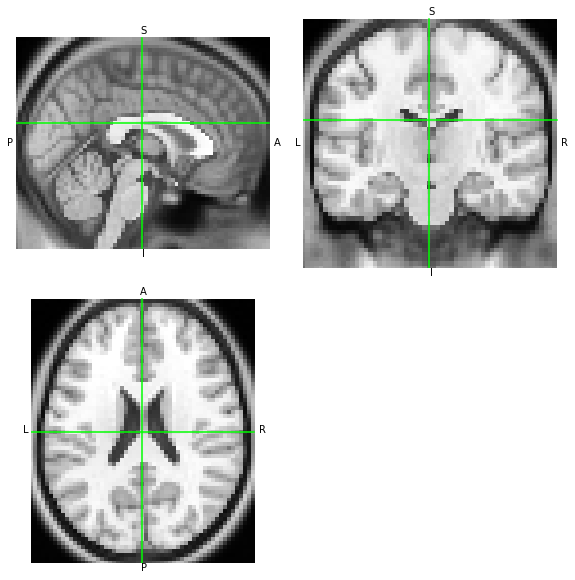

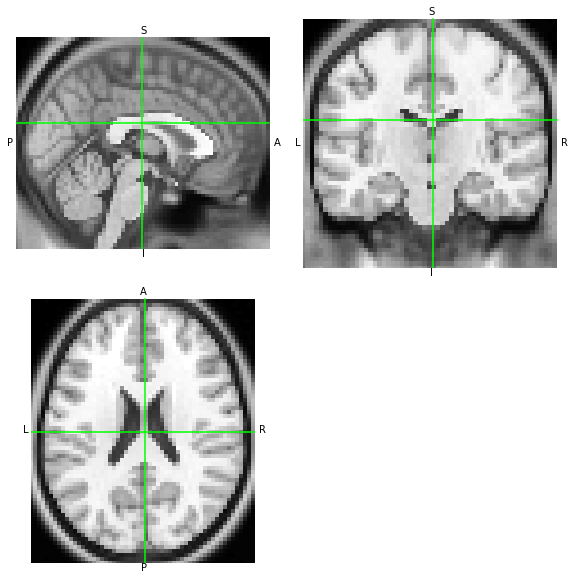

In [7]:
nii.orthoview()
las_anatomy.orthoview()

### Writing a rigid-body transform for *AFNI*, *ANTs*, and *FSL*
Now, let's use these variants to check how they affect in concatenation with other transforms

First, we check that, as *NiBabel* represents the data array disregarding the affine, the `.orthoview()` visualization of the *oblique* image shows the same apparent data orientation as for the original file.

**Create a transform**. We test with a rigid-body transformation with 3 rotations and 3 translations

In [8]:
T = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.9, y=0.001, z=0.001), [4.0, 2.0, -1.0])

**Resampling the image with *NiTransforms***.
Let's resample the dataset using *NiTransforms*. We will be using the LAS image as reference, which means that it will define the output space, and the RAS conversion as moving image -- where the actual values are drawn and moved from. This result should be similar with the other libraries.

In [9]:
xfm = nt.linear.Affine(T)
xfm.reference = las_anatomy

In [10]:
moved = apply(xfm, nii, order=0)
moved.to_filename('moved-nb.nii.gz')

<OrthoSlicer3D: moved-nb.nii.gz (57, 67, 56)>

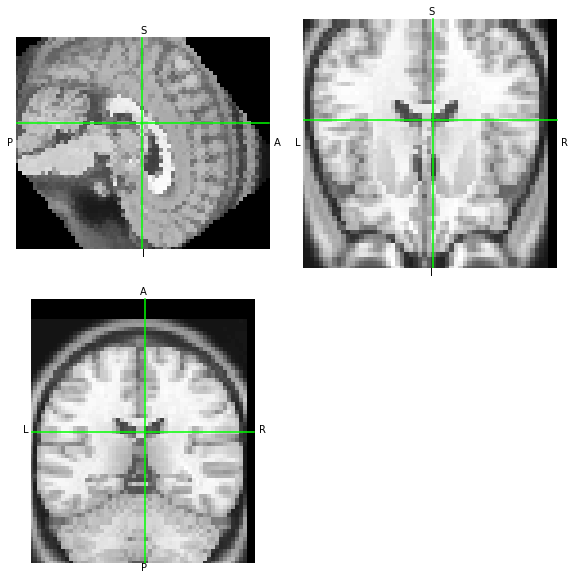

In [11]:
moved.orthoview()

**Store the transform in other formats**. Let's leverage *NiTransforms*' features to store the transforms for ANTs, FSL, and AFNI.
Because transforms can (generally) take any extension, for *NiTransforms* to know the format of the output we will need to inform the transform object's method about the format with the `fmt` argument.

The transform object (`xfm` in this notebook) has a convenient method `to_filename()`.
This method calls internally a factory class that assigns the correct type from `nitransforms.io` to correctly write out the output.
`to_filename()` accepts a `moving` argument, and makes use of the `reference` property for those packages which require them (for example, FSL requires both, FreeSurfer LTAs writes their characteristics in the output file --although only necessary when the transform type is voxel-to-voxel,-- and AFNI needs them only if the data array is not aligned with the cardinal axes --*oblique*).

In [12]:
xfm.to_filename('M.tfm', fmt='itk')
xfm.to_filename('M.fsl', moving=las_anatomy, fmt='fsl')  # reference is set in the xfm object
xfm.to_filename('M.afni', moving=las_anatomy, fmt='afni')  # reference is set in the xfm object
!ls

M.afni          M.fsl           M.tfm           moved-nb.nii.gz


The equivalent way of storing a transform using the low-level interface of the `io` submodule follows.
Let's store the transform `T` into FreeSurfer's LTA format:

In [13]:
lta = nt.io.lta.FSLinearTransform.from_ras(T, moving=las_anatomy, reference=nii)
print(lta.to_string())

# LTA file created by NiTransforms
type      = 1
nxforms   = 1
mean      = 0.0000 0.0000 0.0000
sigma     = 1.0000
1 4 4
9.999990000003335e-01 1.404936252078656e-03 1.617172252089032e-04 -4.002644155280283e+00
-9.999993333334666e-04 6.216088741390577e-01 7.833271395738223e-01 -4.558906113709593e-01
9.999998333333415e-04 -7.833265179640611e-01 6.216096574657062e-01 2.184262694060495e+00
0.000000000000000e+00 0.000000000000000e+00 0.000000000000000e+00 1.000000000000000e+00
src volume info
valid = 1  # volume info valid
filename = /Users/oesteban/datalad/nitransforms-tests/someones_anatomy.nii.gz
volume = 57 67 56
voxelsize = 2.750000000000000e+00 2.750000000000000e+00 2.750000000000000e+00
xras   = 1.000000000000000e+00 0.000000000000000e+00 0.000000000000000e+00
yras   = 0.000000000000000e+00 1.000000000000000e+00 0.000000000000000e+00
zras   = 0.000000000000000e+00 0.000000000000000e+00 1.000000000000000e+00
cras   = 3.750000000000000e-01 1.125000000000000e+00 -1.400000000000000e+01
d

### Applying the transforms we generated before on images
Now, let's check that the transforms written out by *NiTransforms* generate the same output as the tool generated with the `apply()` method when used with their corresponding software packages.

First, we will need to store a copy of our reference and moving images to the temporal directory where we are working:

In [14]:
nii.to_filename("someones_anatomy_RAS.nii.gz")
las_anatomy.to_filename("someones_anatomy_LAS.nii.gz")

**The AFNI use-case**.
Let's apply AFNI's `3dAllineate` to resample `someones_anatomy_LAS.nii.gz` into the grid of `someones_anatomy_RAS.nii.gz` through the affine we generated above:

In [15]:
!3dAllineate -base someones_anatomy_RAS.nii.gz -input someones_anatomy_LAS.nii.gz -1Dmatrix_apply M.afni -prefix moved-afni.nii.gz -final NN
moved_afni = nb.load('moved-afni.nii.gz')

++ 3dAllineate: AFNI version=AFNI_16.0.00 (Jan  1 2016) [64-bit]
++ Authored by: Zhark the Registrator
** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_RAS.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Source dataset: ./someones_anatomy_LAS.nii.gz
++ Base dataset:   ./someones_anatomy_RAS.nii.gz
++ You might want to use '-master' when using '-1D*_apply'
++ Loading datasets
++ NOTE: base and source coordinate systems have different handedness
 +       Orientations: base=Right handed (LPI); source=Left handed (RPI)
++ master dataset for output = base
++ OpenMP thread count = 4
++ ========== Applying transformation to 1 sub-bricks ==========
++ ========== sub-brick #0 ========== [total CPU to here=0.1 s]
++ Output dataset ./moved-afni.nii.gz
++ 3dAllineate: total CPU time = 0.1 sec  Elapsed = 0.1
++ ###########################################################


Now, the two resampled images --`moved` which we generated at the beginning using *NiTransforms*' `apply`, and `moved_afni` just generated using `3dAllineate`-- should look the same.

<OrthoSlicer3D: moved-afni.nii.gz (57, 67, 56)>

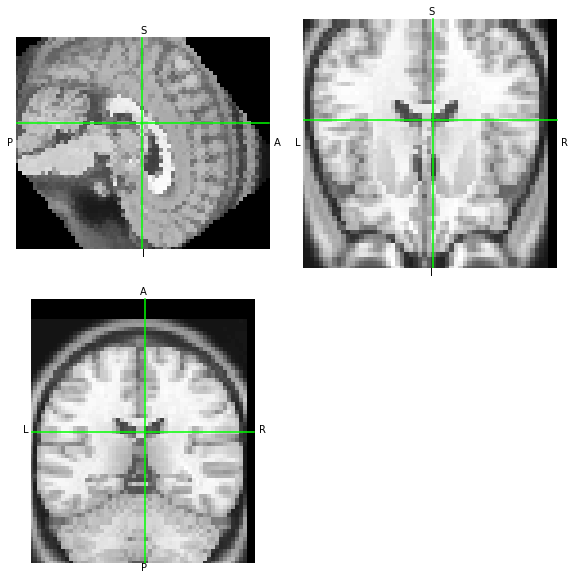

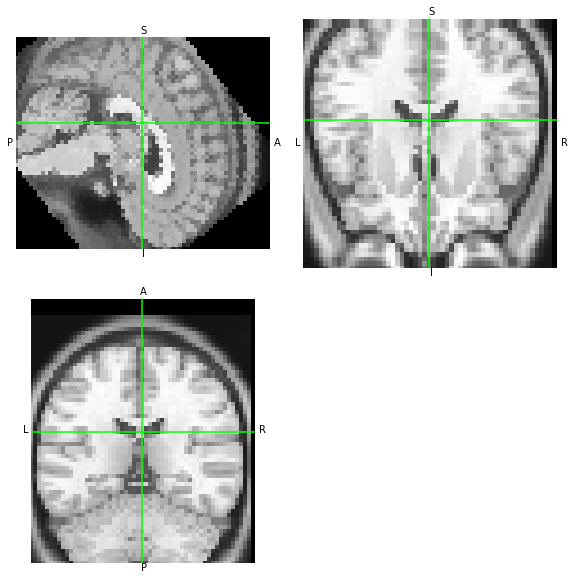

In [16]:
moved.orthoview()
moved_afni.orthoview()

**ANTs/ITK transforms**.
Similarly, let's test `antsApplyTransforms`

<OrthoSlicer3D: moved-itk.nii.gz (57, 67, 56)>

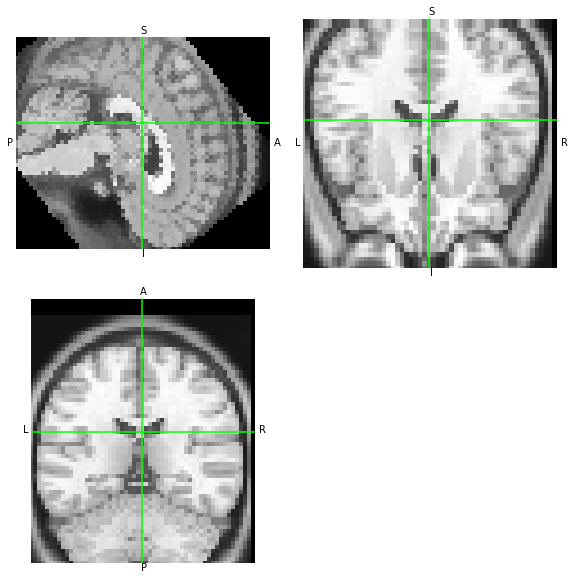

In [17]:
!antsApplyTransforms -d 3 -i 'someones_anatomy_LAS.nii.gz' -r 'someones_anatomy_RAS.nii.gz' -o 'moved-itk.nii.gz' -n 'NearestNeighbor' -t 'M.tfm' --float
nb.load('moved-itk.nii.gz').orthoview()

**FSL**.
Finally, let's check with FSL `flirt`

<OrthoSlicer3D: moved-fsl.nii.gz (57, 67, 56)>

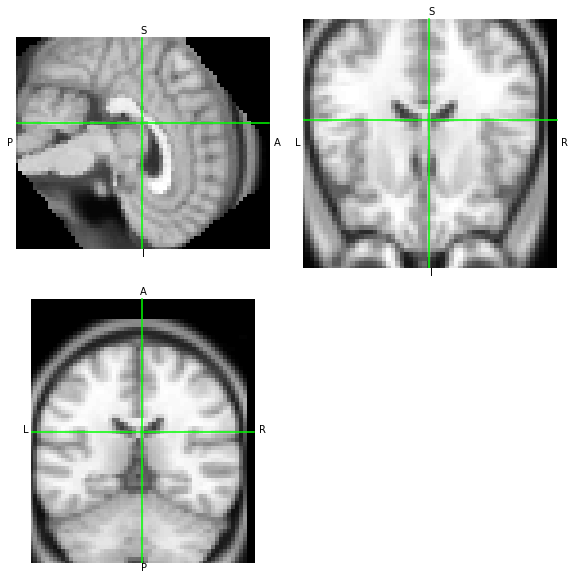

In [18]:
!flirt -in someones_anatomy_LAS.nii.gz -ref someones_anatomy_RAS.nii.gz -out moved-fsl.nii.gz -init M.fsl -applyxfm
nb.load('moved-fsl.nii.gz').orthoview()

### The special case of *oblique* datasets and AFNI
AFNI implements spatial transforms in physical coordinates (mm), so it doesn't generally require to know about the reference and moving images to calculate coordinate mappings (obviously, both are required when *applying* the transform to align one another).

Let's use an oblique dataset rotated 0.2 rad around the X axis and 0.1 rad around Y for the `reference` image in this case.

In [19]:
oblique, _ = _generate_reoriented(anat_file, (1, 1, 1), None, {"x": 0.2, "y": 0.1, "z": 0})
print("Dataset is oblique" if nt.io.afni._is_oblique(oblique.affine) else "not oblique (?)")
oblique.to_filename("oblique.nii.gz")

Dataset is oblique


Let's first check the contents of the output file when neither the reference nor the moving images were oblique:

In [20]:
nonoblique_M = nt.io.afni.AFNILinearTransform.from_ras(T, moving=las_anatomy, reference=nii)
print(nonoblique_M.to_string())

# 3dvolreg matrices (DICOM-to-DICOM, row-by-row):
0.999999	-0.000999999	-0.001	-4	0.00140494	0.621609	0.783327	-2	-0.000161717	-0.783327	0.62161	-1



Now, let's replace the reference with the oblique image:

In [21]:
oblique_M = nt.io.afni.AFNILinearTransform.from_ras(T, moving=las_anatomy, reference=oblique)
oblique_M.to_filename("M.oblique.afni")
print(oblique_M.to_string())

# 3dvolreg matrices (DICOM-to-DICOM, row-by-row):
0.994885	-0.000781397	-0.101006	-13.492	0.0903701	0.453595	0.886614	12.7541	0.0451231	-0.891208	0.451346	-13.9663



It is apparent that the transform is not the same as above anymore.
Let's see whether AFNI interprets these new parameters correctly.

In [22]:
!3dAllineate -base oblique.nii.gz -input someones_anatomy_LAS.nii.gz -1Dmatrix_apply M.oblique.afni -prefix moved-afni-oblique.nii.gz -final NN
moved_afni = nb.load('moved-afni-oblique.nii.gz')

++ 3dAllineate: AFNI version=AFNI_16.0.00 (Jan  1 2016) [64-bit]
++ Authored by: Zhark the Registrator
*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
  such as oblique.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:oblique.nii.gz is 12.794579 degrees from plumb.
++ Source dataset: ./someones_anatomy_LAS.nii.gz
++ Base dataset:   ./oblique.nii.gz
++ You might want to use '-master' when using '-1D*_apply'
++ Loading datasets
++ NOTE: base and source coordinate systems have different handedness
 +       Orientations: base=Right handed (LPI); source=Left handed (RPI)
++ master dataset for output = base
++ OpenMP thread count = 4
++ ========== Applying transformation to 1 sub-bricks ==========
++ ========== sub-brick #0 ========== [total CPU to here=0.1 s]
++ Output datas

Looking closely at the standard output of `3dAllineate` we can spot that the dataset is correctly identified as oblique, and AFNI triggers the special behavior of *deobliquing* it:
```
*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
  such as oblique.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:oblique.nii.gz is 12.794579 degrees from plumb.
```

Let's now run the corresponding operation with our original `xfm` object.
First, we need to replace the old reference, then execute `apply()`:

In [23]:
xfm.reference = oblique
moved_oblique = apply(xfm, las_anatomy)

The outputs of AFNI and *NiTransforms* should be consistent:

<OrthoSlicer3D: (57, 67, 56)>

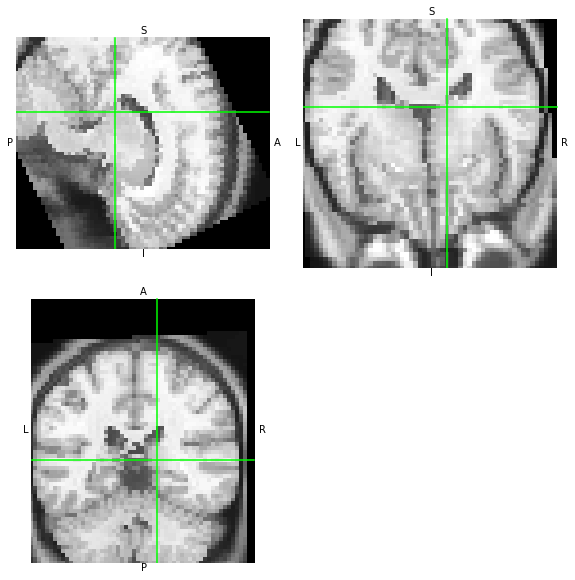

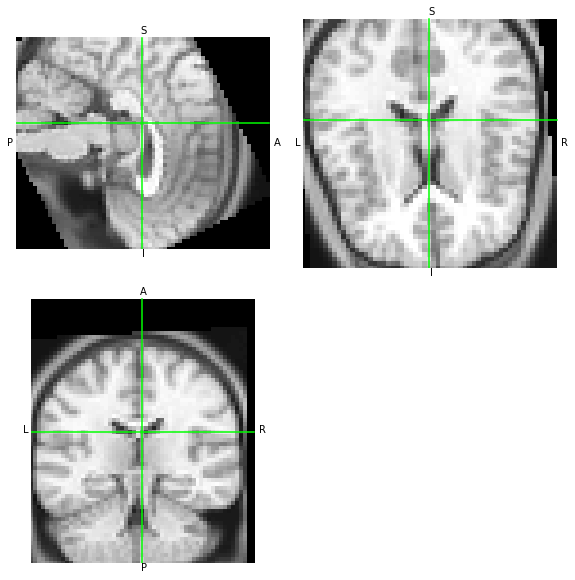

In [24]:
moved_afni.orthoview()
moved_oblique.orthoview()

**WAT??** O_O the two images do not match. Let's look at the affines of each.

In [25]:
moved_afni.affine[:3, ...].round(2), moved_oblique.affine[:3, ...].round(2)

(array([[  2.75,  -0.  ,  -0.  , -86.7 ],
        [ -0.  ,   2.75,  -0.  , -72.74],
        [  0.  ,   0.  ,   2.75, -99.19]]),
 array([[ 2.740e+00,  0.000e+00,  2.700e-01, -8.670e+01],
        [ 5.000e-02,  2.700e+00, -5.400e-01, -7.274e+01],
        [-2.700e-01,  5.500e-01,  2.680e+00, -9.919e+01]]))

We can see that AFNI has generated a dataset without obliquity.
If both tools are generating the same data at the output with only a difference in the orientation metadata, then both data arrays should be similar -- let's overwrite the metadata and compare visually:

<OrthoSlicer3D: (57, 67, 56)>

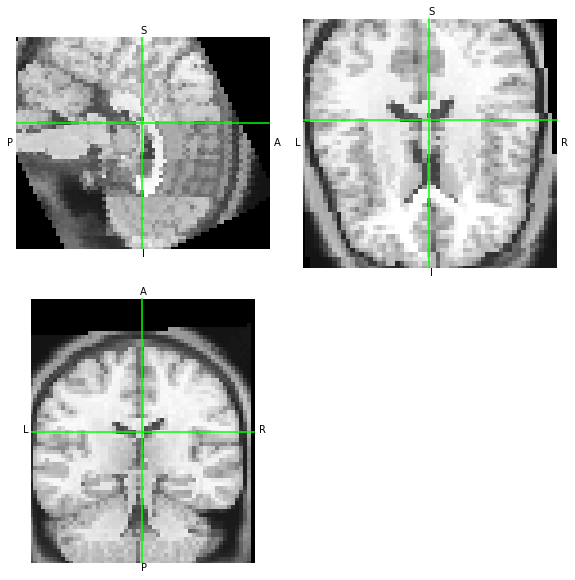

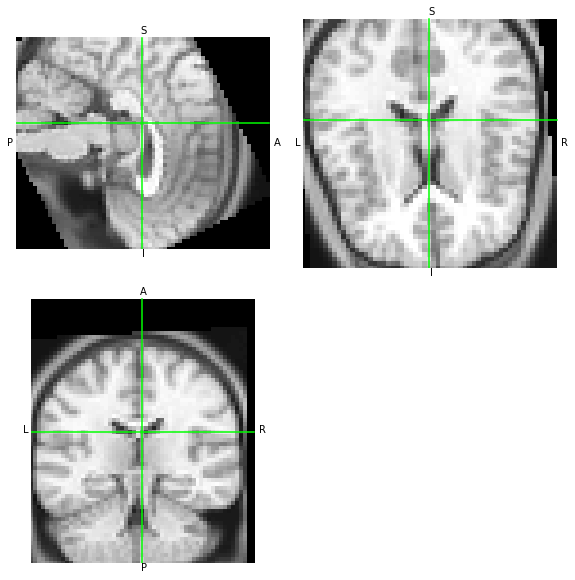

In [26]:
moved_oblique.__class__(
    np.asanyarray(moved_afni.dataobj, dtype="uint8"),
    moved_oblique.affine,
    moved_oblique.header,
).orthoview()
moved_oblique.orthoview()